In [15]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import copy
import torch.utils.data as tdata

import datetime as dt
from matplotlib import style
import pandas_datareader.data as web

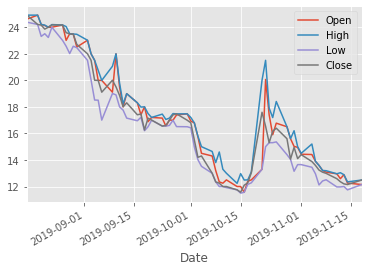

In [16]:
#ESCOPO FUTURO TENTAR PREVER AÇOES REAIS
style.use('ggplot')

start = dt.datetime(2019,8,16)
end = dt.datetime(2019,11,18)

df = web.DataReader('NVHO11.SA', 'yahoo', start, end)
df.to_csv('NVHO11.txt')

df[['Open','High','Low','Close']].plot()



[10.04]
Foram geradas 567 amostras
5.83


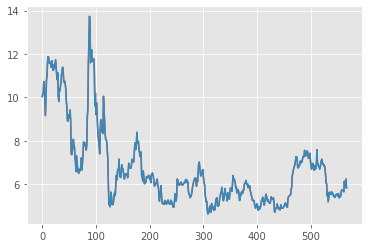

In [17]:
cenario = 'stock'

if (cenario == 'stock'):
    #my_data = genfromtxt('/home/matos/stockMarket/NVHO11.txt', delimiter=',')
    my_data = genfromtxt('/home/matos/stockMarket/data/Stocks/run.us.txt', delimiter=',')
    my_data.shape
    horizon = 6

    h_open = my_data[1:,1]
    h_high = my_data[1:,2]
    h_low = my_data[1:,3]
    h_close = my_data[1:,4]
    h_volume = my_data[1:,5]
    plt.plot(h_close[horizon+1:])
    
    #Inicializando
    index = 0
    sample_index = np.arange(index,index+horizon+1);
    sample_input = np.concatenate((h_open[index:index+horizon+1], h_high[index:index+horizon], h_close[index:index+horizon]),axis=0)
    sample_output = np.asarray(h_close[index+horizon+1])
    dataset_index = np.array([sample_index])
    dataset_input = np.array([sample_input])
    dataset_output = np.array([sample_output])
    
    print(dataset_output)
    
    #Criando os demais samples
    for index in range(1,len(h_open)-horizon-1):
        sample_index = np.arange(index,index+horizon+1);
        sample_input = np.concatenate((h_open[index:index+horizon+1], h_high[index:index+horizon], h_close[index:index+horizon]),axis=0)
        sample_output = np.asarray(h_close[index+horizon+1])

        dataset_index = np.insert(arr=dataset_index, obj=len(dataset_index), values=sample_index, axis=0)
        dataset_input = np.insert(arr=dataset_input, obj=len(dataset_input), values=sample_input, axis=0)
        dataset_output = np.insert(arr=dataset_output, obj=len(dataset_output), values=sample_output, axis=0)

    dataset_output = np.reshape(dataset_output, len(dataset_output),1)

    numSamples = len(dataset_input)
    print("Foram geradas %d amostras"%(numSamples))
    plt.plot(dataset_output)
    print(dataset_output[-1])

Aqui é o cenário de teste, onde as amostras são geradas.

In [18]:
import math
def funcao_teste(x):
    return math.sin(x**2)+x/math.pi

if (cenario == 'teste'):
    my_data = np.arange(0,math.pi,0.001)
    my_data = np.vectorize(funcao_teste)(my_data)
    plt.plot(my_data)
    
    horizon = 3

    #Inicializando
    index = 0
    sample_index = np.arange(index,index+horizon+1);
    sample_input = np.asarray(my_data[index:index+horizon+1])
    sample_output = np.asarray(my_data[index+horizon+1])
    dataset_index = np.array([sample_index])
    dataset_input = np.array([sample_input])
    dataset_output = np.array([sample_output])

    for index in range(1,len(my_data)-horizon-2):
        sample_index = np.arange(index,index+horizon+1);
        sample_input = np.asarray(my_data[index:index+horizon+1])
        sample_output = np.asarray(my_data[index+horizon+1])

        dataset_index = np.insert(arr=dataset_index, obj=len(dataset_index), values=sample_index, axis=0)
        dataset_input = np.insert(arr=dataset_input, obj=len(dataset_input), values=sample_input, axis=0)
        dataset_output = np.insert(arr=dataset_output, obj=len(dataset_output), values=sample_output, axis=0)

    dataset_output = np.reshape(dataset_output, len(dataset_output),1)

    numSamples = len(dataset_input)
    print("Foram geradas %d amostras"%(numSamples))    
    for index in range(0,10):
        print(dataset_input[index], dataset_output[index])
#plt.plot(dataset_output)


Aqui acontece a normalização das entradas e saídas, onde o future_horizon = 10 representa a quantidade de dias futuros que vamos prever.

In [19]:
# Nomalizando as entradas e saídas
max = (np.max([np.max(dataset_input),np.max(dataset_output)]))
min = (np.min([np.min(dataset_input),np.min(dataset_output)]))
print(min,max)

dataset_input = (dataset_input-min)/(max-min)
dataset_output = (dataset_output-min)/(max-min)

future_horizon = 1
future_index = dataset_index[-future_horizon:]
future_input = dataset_input[-future_horizon:]
future_output= dataset_output[-future_horizon:]

dataset_index = dataset_index[1:(numSamples-future_horizon)]
dataset_input = dataset_input[1:(numSamples-future_horizon)]
dataset_output = dataset_output[1:(numSamples-future_horizon)]

print(dataset_index[-1])
print(future_index[0])
#plt.plot(dataset_output)
numSamples = len(dataset_output)
print("Total samples for training: ",numSamples)

4.18 14.95
[565 566 567 568 569 570 571]
[566 567 568 569 570 571 572]
Total samples for training:  565


Aqui são separados 70 % das amostras para treinamento e 30% são para validação, isso acontece por que se usarmos 100% das amostras, vamos estar lidando com valores conhecidos e queremos descobrir novos valores.

In [20]:
#Separando amostras de treinamento e amostras de validação
randomize = np.arange(numSamples)
np.random.shuffle(randomize)
shuffed_input = dataset_input[randomize]
shuffed_output = dataset_output[randomize]

lenghtOfTrainingSet = int(numSamples*0.70)

dataset_validation_input = shuffed_input[lenghtOfTrainingSet:]
dataset_validation_output = shuffed_output[lenghtOfTrainingSet:]
dataset_training_input = shuffed_input[0:lenghtOfTrainingSet+1]
dataset_training_output = shuffed_output[0:lenghtOfTrainingSet+1]

lenghtOfTrainingSet = len(dataset_training_input)  #MUDEI AQUI TAVA ERRADO  70%
lenghtOfValidationSet = len(dataset_validation_input)  # 30 %

print("tr",lenghtOfTrainingSet)
print("vt", lenghtOfValidationSet)

train = torch.utils.data.TensorDataset(torch.Tensor(dataset_training_input), torch.Tensor(dataset_training_output))
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

test = torch.utils.data.TensorDataset(torch.Tensor(dataset_validation_input), torch.Tensor(dataset_validation_output))
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

print('train_dataloader tem %d batches'%(len(train_loader)))
print('test_dataloader tem %d batches'%(len(test_loader)))


tr 396
vt 170
train_dataloader tem 40 batches
test_dataloader tem 17 batches


Aqui é criado a Rede Neural, e o nn.Module é usado para um ciclo de treinamento mais claro e conciso. Também é verificado se a Rede Neural está funcionando como deveria, tambem são criado os metodos para previsão e para obtençao de precisão. Foi usado a função de ativação Relu para todos os neurônios.

In [21]:
#Cria a rede neural
input_dim = len(dataset_input[0])
output_dim = 1

class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(input_dim, horizon*3*2+1),
            nn.ReLU(),
            nn.Linear(horizon*3*2+1, output_dim),
        )
    
    def forward(self, x):
        x = self.dense(x)        
        return x
    
    def clone(self):
        model_copy = type(self)() # get a new instance
        model_copy.load_state_dict(self.state_dict()) # copy weights and stuff        
        return model_copy
    
model = Modelo()
print(model)

# Verifica a rede neural

test_input  = torch.FloatTensor(3, input_dim)  # 3 amostras aleatórias para teste
test_output = model(Variable(test_input))

if test_output.size(1) == output_dim and test_output.size(0) == test_input.size(0):
    print('Rede está funcionando corretamente')
elif test_output.size(1) != output_dim:
    print('Saída da rede deve ter dimensão (n_amostras, %d), mas tem dimensão (%d, %d)'%(output_dim,test_output.size(0), test_output.size(0)))
elif test_output.size(0) != test_input.size(0):
    print('Número de amostras na saída (%d) deve ser igual ao da entrada (%d)'%(test_output.size(0), test_input.size(0)))
    

def predict(model, inputs):
    if (isinstance(inputs,np.ndarray)):
        inputs = torch.FloatTensor(inputs)
    outputs = model(Variable(inputs))
    return outputs.data.numpy()

def getAccuracy(model, inputs, targets):
    if (isinstance(inputs,np.ndarray)):
        inputs = torch.FloatTensor(inputs)

    outputs = model(Variable(inputs))
    outputs = outputs.data.numpy()
    
    if (isinstance(targets,torch.Tensor)):
        targets  = targets.numpy().reshape(len(targets),1)

    accuracy = ((outputs - targets) ** 2).mean(axis=0)
 
    return accuracy

predict(model,dataset_training_input[0])

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=19, out_features=37, bias=True)
    (1): ReLU()
    (2): Linear(in_features=37, out_features=1, bias=True)
  )
)
Rede está funcionando corretamente


array([-0.07669785], dtype=float32)

Aqui, são inicializados os parâmetros da rede, onde a taxa de aprendizado é um hiperparâmetro que controla o quanto estamos ajustando os pesos de nossa rede em relação ao gradiente de perda. Quanto menor o valor, mais lento viajamos ao longo da inclinação descendente. Embora possa ser uma boa ideia (usando uma baixa taxa de aprendizado) em termos de garantir que não perdemos nenhum mínimo local, isso também pode significar que levaremos muito tempo para convergir, especialmente se ficarmos presos uma região de planalto. Foi alterado o valor da taxa de aprendizado diversas vezes afim de obter uma saída ideal.

Foi usado o método Adam como otimizador para controlar a taxa de aprendizado. Ele usa médias móveis dos parâmetros que permitem ter um tamanho de etapa maior. Tentei utilizar outros otimizadores o RMSprop e o ASGD principalmente, deram bons resultados porém para um prazo menor de dias. A melhor opção foi utilizar o Adam.
    
Por fim, apos realizado o treinamento, obtemos a saída como mostra o gráfico é possível observar que a previsão está bem próxima do fechamento real na maior parte do tempo, isso indica que possívelmente a nossa Rede Neural vai acertar na alta e baixa.

Checkpoint on epoch 0. Loss = 0.003050
[0] Train Loss=0.000370  Validation Loss=0.003050


/home/matos/stockMarket/lib/python3.7/site-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Checkpoint on epoch 1. Loss = 0.002738
Checkpoint on epoch 2. Loss = 0.002684
Checkpoint on epoch 3. Loss = 0.002673
Checkpoint on epoch 4. Loss = 0.002668
Checkpoint on epoch 5. Loss = 0.002667
Checkpoint on epoch 6. Loss = 0.002667
Checkpoint on epoch 7. Loss = 0.002667
Checkpoint on epoch 8. Loss = 0.002667
Checkpoint on epoch 9. Loss = 0.002667
[100] Train Loss=0.000596  Validation Loss=0.002667
Final loss: 0.00023596452
Modelo(
  (dense): Sequential(
    (0): Linear(in_features=19, out_features=37, bias=True)
    (1): ReLU()
    (2): Linear(in_features=37, out_features=1, bias=True)
  )
)
Training Accuracy:  [0.00298986]
Test Accuracy:  [0.00266706]
Training Accuracy:  [0.00298986]
Test Accuracy:  [0.00266706]
[0.19670956] 0.17548746518105857
[566 567 568 569 570 571 572]
[565 566 567 568 569 570 571]
[0.1457753  0.13834726 0.14763231 0.13834726 0.1457753  0.18755803
 0.15227484 0.16155989 0.15413185 0.15041783 0.14298979 0.18384401
 0.1908078  0.1448468  0.1448468  0.14020427 0.1

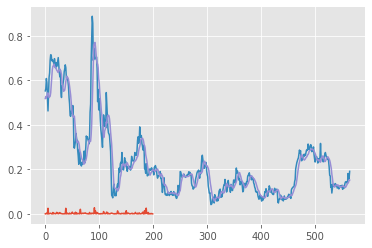

In [22]:
# Inicializando parâmetros da rede
#learningRate = 0.01
learningRate = 0.0256
#learningRate = 0.05
# Utilizaremos MSELoss como função de perda
criterion = torch.nn.MSELoss(reduction='elementwise_mean')

# Nosso otimizador será Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
#optimizer = torch.optim.Adamax(model.parameters(), lr=learningRate)
#optimizer = torch.optim.AdamW(model.parameters(), lr=learningRate)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learningRate)
#optimizer = torch.optim.ASGD(model.parameters(), lr=learningRate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

#Loop de treinamento
epochs = 200
# Pega todas as imagens de uma vez
#inputs, targets = next(iter(train_dataloader))
# Transforma em vetor
losses = []
checkpoint = {"model":copy.deepcopy(model), "train_loss":10e10, "validation_loss":10e10, "best_epoch":0}
validation_input_tensor = torch.FloatTensor(dataset_validation_input)
validation_output_tensor = torch.FloatTensor(dataset_validation_output)

for epoch in range(epochs):
    for inputs,targets in train_loader:
        targets = targets.reshape(len(inputs),1)
        # predict - forward
        output = model(Variable(inputs))
        # calcula a perda
        loss = criterion(output, Variable(targets))
        # Zero, backpropag gradientes, ajusta parâmetros gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    #Checkpoint
    tloss = loss.data
    vloss = getAccuracy(model, validation_input_tensor, validation_output_tensor)
    if vloss < checkpoint['validation_loss']:
        checkpoint['validation_loss'] = vloss
        checkpoint['train_loss'] = tloss
        checkpoint['best_epoch'] = epoch
        checkpoint['model'] = model.clone()
        print('Checkpoint on epoch %d. Loss = %f'%(epoch,vloss))
    #Print
    losses.append(loss.data)
    if (epoch%100 == 0):
        print("[%d] Train Loss=%f  Validation Loss=%f"%(epoch,tloss,vloss))

final_model = copy.deepcopy(model);
print('Final loss:', loss.data.numpy())
print(str(model))

plt.plot(losses)
#Last model
model = final_model
inputs = torch.FloatTensor(dataset_training_input)
targets = torch.FloatTensor(dataset_training_output)
print('Training Accuracy: ', getAccuracy(model, inputs, targets))

inputs = torch.FloatTensor(dataset_validation_input)
targets = torch.FloatTensor(dataset_validation_output)
print('Test Accuracy: ', getAccuracy(model, inputs, targets))

output_last = predict(model,dataset_input)

#Best model
model = checkpoint['model']
inputs = torch.FloatTensor(dataset_training_input)
targets = torch.FloatTensor(dataset_training_output)
print('Training Accuracy: ', getAccuracy(model, inputs, targets))

inputs = torch.FloatTensor(dataset_validation_input)
targets = torch.FloatTensor(dataset_validation_output)
print('Test Accuracy: ', getAccuracy(model, inputs, targets))

inputs = dataset_validation_input[0]
output = predict(model,inputs)
print(output,dataset_validation_output[0])

output_best = predict(model,dataset_input)

plt.plot(dataset_output)
#plt.plot(output_last)
plt.plot(output_best)

index = dataset_index[-1][1]
test_index = np.arange(index,index+horizon+1);
test_input = np.concatenate((h_open[index:index+horizon+1], h_high[index:index+horizon], h_close[index:index+horizon]),axis=0)
test_output = np.asarray(h_close[index+horizon+1])

test_input = (test_input-min)/(max-min)
test_output = (test_output-min)/(max-min)

output = predict(model,test_input) 

open = (h_open[index+horizon+1]-min)/(max-min) ;
predicted = output;
real = test_output;

print(test_index)
print(dataset_index[-1])
print(dataset_input[-1])
print(test_input)
print("Open:",open)
print("Predicted:",output)
print("Real",test_output)


A classe Market é responsável pelo preço e derivativo.

In [23]:
class Market:
    def __init__(self, price, derivative):
        self.derivative = derivative
        self.price = price
    def setDerivative(self, derivative):
        self.derivative = derivative
        return derivative
    def setPrice(self, price):
        self.price = price
        return price
    def getDerivative(self):
        return self.derivative
    def getPrice(self):
        return self.price
  

A classe Wallet é responsavel pelo dinheiro inicial, o dinhero após a compra e a quantidade de ações.

In [24]:
class Wallet():
    def __init__(self, money, amount_ofMoney, amount_ofDerivative):
        self.money = money
        self.amount_ofMoney = amount_ofMoney
        self.amount_ofDerivative = amount_ofDerivative
    
    def setMoney(self, money):
        self.money = money
        return money   
    def setAmount_ofDerivative(self, amount_ofDerivative):
        self.amount_ofDerivative  = amount_ofDerivative 
        return amount_ofDerivative 
    def setAmount_ofMoney(self, amount_ofMoney):
        self.amount_ofMoney = amount_ofMoney
    
    def getMoney(self):
        return self.money
    def getAmount_ofDerivative(self):
        return self.amount_ofDerivative
    def getAmount_ofMoney(self):
        return self.amount_ofMoney   

Aqui é confirmado a compra da ação dado uma certa quantidade solicitada pelo usuário.

In [25]:
openReal = open * 100
predictedReal = float(output * 100) 
closeReal = test_output * 100
print("O preço do derivativo hoje é de:", openReal)
qtd = float(input("Quantas ações você deseja comprar: "))

w = Wallet(500, 0, qtd)
m = Market(openReal, 0)
qtdBuy = m.getPrice() * w.getAmount_ofDerivative()
print("O preço final dessa compra vai ser de: ", (qtdBuy))

if(qtdBuy > w.getMoney()): 
    print("Você não tem saldo suficiente......") 
    print("Por favor, adicione mais dinheiro na sua carteira!") 
    qtdBuy = 0 
elif(qtdBuy < w.getMoney()): 
    passw = input("Digite sua senha para confirmar a compra: ") 
if (passw == "1234"):
    print("Compra efetuada! ") 
    print("Sua carteira tinha um saldo de: ", w.getMoney()) 
    w.setAmount_ofMoney(w.getMoney() - qtdBuy)
    print("Agora seu saldo é de: ", w.getAmount_ofMoney()) 
    print("Sua carteira de ações é de: ", qtdBuy) 
    print("Em seu poder você tem: ", qtd) 
else: print("SENHA INCORRETA!")

O preço do derivativo hoje é de: 18.75580315691737
Quantas ações você deseja comprar: 1
O preço final dessa compra vai ser de:  18.75580315691737
Digite sua senha para confirmar a compra: 1234
Compra efetuada! 
Sua carteira tinha um saldo de:  500
Agora seu saldo é de:  481.24419684308265
Sua carteira de ações é de:  18.75580315691737
Em seu poder você tem:  1.0


Aqui é a lógica de compra e venda.

In [27]:
previousWallet = qtdBuy
walletNow = 0
for i in range(future_horizon):
   
    indexf = future_index[-1+i][1]
    openI = future_input[i]
    closef  = future_output[i]
    outputf = predict(model, openI)
    openf = (h_open[indexf]-min)/(max-min)
    opening = openf * 100
    prediction = float(outputf* 100)
    closure = closef * 100
       
    #VENDAS 
    
    #SE A PREDIÇÃO FOR MAIOR QUE 1.5% VENDA 5% DAS AÇÕES
    biggestOpening01_5= (opening * 0.015) + opening
    #SE A PREDIÇÃO FOR MAIOR QUE 3% VENDA 9% DAS AÇÕES
    biggestOpening03 = (opening * 0.03) + opening
    #SE A PREDIÇÃO FOR MAIOR QUE 5% VENDA 10% DAS AÇÕES
    biggestOpening05 = (opening * 0.05) + opening
    #SE A PREDIÇÃO FOR MAIOR QUE 10% VENDA 15% DAS AÇÕES
    biggestOpening10 = (opening * 0.1) + opening
    #SE A PREDIÇAO FOR MAIOR QUE 20%, VENDE 20% DA AÇOES
    biggestOpening20 = (opening * 0.2) + opening 
    #SE A PREDIÇÃO FOR MAIOR QUE 30% VENDE 30% DAS AÇÕES
    biggestOpening30 = (opening * 0.3) + opening 
    #SE A PREDIÇÃO FOR MAIOR QUE 40% VENDE 40% DAS AÇÕES
    biggestOpening40 = (opening * 0.4) + opening 
    #SE A PREDIÇÃO FOR MAIOR QUE 50% VENDE 100% DAS AÇÕES
    biggestOpening50 = (opening * 0.5) + opening 

    #SEGURANÇA
    
    #SE A PREDIÇÃO FOR MENOR QUE < 0 % VENDER 5% DAS AÇÕES
    smallestOpening_0 = opening - (opening * 0.001)
    #SE A PREDIÇÃO FOR MENOR QUE < -2% VENDER 15% DAS AÇÕES
    smallestOpening__2 = opening - (opening * 0.02) 
    #SE A PREDIÇÃO FOR MENOR QUE < -4% VENDER 25% DAS AÇÕES
    smallestOpening__4 = opening - (opening * 0.04)
    #SE A PREDIÇÃO FOR MENOR QUE < -6% VENDER 50% DAS AÇÕES
    smallestOpening__6 = opening - (opening * 0.06)
    #SE A PREDIÇÃO FOR MENOR QUE < -8% VENDER 100% DAS AÇÕES
    smallestOpening__8 = opening - (opening * 0.08)
        
         
    if(prediction < smallestOpening_0 and prediction > smallestOpening__2):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: BAIXO em 0%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow =previousWallet - (previousWallet * 0.05)  # VENDE 10%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
    
    elif(prediction < smallestOpening__2 and prediction > smallestOpening__4):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: BAIXO em -2%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow =  previousWallet - (previousWallet * 0.17) # VENDE 30%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
    
    elif(prediction < smallestOpening__4 and prediction > smallestOpening__6):
        print("*******************************************************")  
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: BAIXO em -4%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        
        walletNow = previousWallet - (previousWallet * 0.25) # VENDE 50%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
        
    elif(prediction < smallestOpening__6 and prediction > smallestOpening__8 ):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: BAIXO em -6%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = previousWallet - (previousWallet * 0,50) # VENDE 100%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
    
    elif(prediction < smallestOpening__8):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: BAIXO em -6%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = previousWallet - (previousWallet * 0,999) # VENDE 100%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
       
    if(prediction > biggestOpening01_5 and prediction < biggestOpening03):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: ALTA em 1.5%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = (previousWallet * 0.015) + previousWallet # VENDE 1.5%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
        
    elif(prediction > biggestOpening03 and prediction < biggestOpening05):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: ALTA em 3%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = (previousWallet * 0.03) + previousWallet # VENDE 3%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
        
    elif(prediction > biggestOpening05 and prediction < biggestOpening10):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: ALTA em 5%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = (previousWallet * 0.05) + previousWallet # VENDE 5%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
    
    elif(prediction > biggestOpening10 and prediction < biggestOpening20):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: ALTA em 10%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = (previousWallet * 0.10) + previousWallet # VENDE 10%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
    
    elif(prediction > biggestOpening20 and prediction < biggestOpening30):
        print("*******************************************************")
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: ALTA em 20%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = (previousWallet * 0.2) + previousWallet # VENDE 20%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
    
    elif(prediction > biggestOpening30 and prediction < biggestOpening50):
        print("*******************************************************")
        previousWallet = walletNow
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: ALTA em 30%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = (previousWallet * 0.3) + previousWallet # VENDE 30%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
    
    elif(prediction > biggestOpening50):
        print("*******************************************************")
        previousWallet = walletNow
        print("Sua carteira era de: ", previousWallet)
        print("A previsão de hoje é de: ALTA em 50%")
        print("A previsão é de: ", prediction)
        print("A abertura de hoje foi de:", opening)
        print("O fechamento foi de: ", closure)
        walletNow = (previousWallet * 0.50) + previousWallet # VENDE 50%
        print("Sua carteira agora é de:", walletNow)
        previousWallet = walletNow
   
    print("Dia", i+1)
       
print("******************************************************")
profitFinal = walletNow
if(w.getMoney() < (w.getMoney() + walletNow)):
    print("No final de 10 dias você lucrou: ", profitFinal)
else:
    print("No final de 10 dias você perdeu: ", profitFinal)
    
print("Sua carteira era de: ", w.getMoney())
print("Agora é de: ", w.getMoney() + walletNow)
print("******************************************************")   

*******************************************************
Sua carteira era de:  18.75580315691737
A previsão de hoje é de: ALTA em 5%
A previsão é de:  16.171497344970703
A abertura de hoje foi de: 14.763231197771587
O fechamento foi de:  15.320334261838445
Sua carteira agora é de: 19.693593314763238
Dia 1
******************************************************
No final de 10 dias você lucrou:  19.693593314763238
Sua carteira era de:  500
Agora é de:  519.6935933147632
******************************************************


# Coclusão

Os preços das ações podem ser previstos até certo ponto pois há perda de precisão, para melhor precisão o modelo deve ser treinado com dados atualizados. Entretanto, o resultado foi satisfatório uma vez que após os 10 dias o resultado foi de lucro!